In [1]:
import random
import time
random.seed(time.time())

In [2]:
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import numpy as np
import pandas as pd
import networkx as nx

In [3]:
%matplotlib inline
# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [4]:
import ipywidgets as widgets

### Matrix input

In [5]:
states_number_input = widgets.BoundedIntText(value=0, min=0, max=100, step=1,
                                             layout=widgets.Layout(width="50px"))

randomize_input = widgets.Checkbox(value=False, description='Случайное заполнение', indent=False)

display(widgets.Label("Количество состояний в системе"))
display(states_number_input)
display(randomize_input)

Label(value='Количество состояний в системе')

BoundedIntText(value=0, layout=Layout(width='50px'))

Checkbox(value=False, description='Случайное заполнение', indent=False)

In [6]:
states_n = states_number_input.value

matrix_inputs = []
items = []

items += [widgets.Label("Состояния")]
items += [widgets.Label(f"$\\text{{в }}S_{{{i+1}}}$") for i in range(states_n)]

for i in range(states_n):
    items += [widgets.Label(f"$\\text{{из }}S_{{{i+1}}}$")]
    
    inputs = [
        widgets.BoundedFloatText(value=0 if not randomize_input.value else round(random.random(), 2), min=0, max=10, step=0.01,
                                 layout=widgets.Layout(width="50px"))
        for _ in range(states_n)
    ]
    matrix_inputs += [inputs]
    items += inputs

display(widgets.Label("Таблица вероятностей перехода"))
display(widgets.GridBox(items, layout=widgets.Layout(grid_template_columns=f"repeat({states_n + 1}, 1fr)", overflow="auto")))

Label(value='Таблица вероятностей перехода')

GridBox(children=(Label(value='Состояния'), Label(value='$\\text{в }S_{1}$'), Label(value='$\\text{в }S_{2}$')…

In [7]:
def get_matrix():
    return np.array([[float(matrix_inputs[i][j].value) for j in range(states_n)] 
             for i in range(states_n)])

### Graph

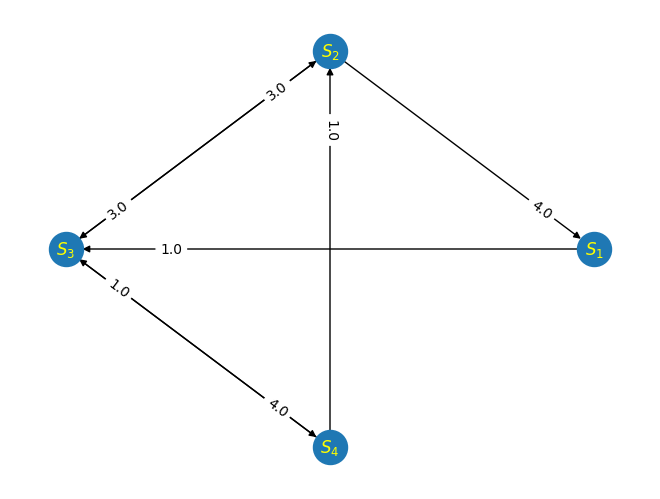

In [8]:
def draw_graph(matrix) -> None:
    G = nx.from_numpy_matrix(matrix, create_using=nx.DiGraph)
    layout = nx.circular_layout(G)

    nx.draw(G, layout, node_size=600)
    nx.draw_networkx_labels(
        G,
        pos=layout,
        labels={i: f"$S_{i+1}$" for i in range(len(matrix))},
        font_color="yellow",
        font_size=12,
    )
    nx.draw_networkx_edge_labels(
        G, pos=layout, edge_labels=nx.get_edge_attributes(G, "weight"), label_pos=0.2
    )
    plt.show()
    
draw_graph(get_matrix())

### Solution

In [9]:
t_max_input = widgets.BoundedFloatText(value=0, min=0, max=1000, step=1, description="Tmax")
t_n_input = widgets.BoundedIntText(value=0, min=0, max=10e4, step=1, description="N")

display(widgets.Label("Время моделирования"))
display(t_max_input)
display(t_n_input)

Label(value='Время моделирования')

BoundedFloatText(value=0.0, description='Tmax', max=1000.0, step=1.0)

BoundedIntText(value=0, description='N', max=100000)

In [10]:
def find_steady_ps(matrix: np.ndarray) -> np.ndarray:
    b = np.array([0] * (len(matrix) - 1) + [1])

    matrix_to_solve = matrix.copy().transpose()
    matrix_to_solve -= np.diag(matrix.sum(axis=1))
    matrix_to_solve[-1] = np.ones(len(matrix_to_solve))

    return np.linalg.solve(matrix_to_solve, b)

In [11]:
def find_steady_ts(
    ts: np.ndarray, ps: np.ndarray, steady_ps: np.ndarray, eps: float = 1e-6
) -> np.ndarray:
    steady_ts = np.zeros(len(steady_ps))

    for i, row in enumerate(ps):
        for p, t in reversed(list(zip(row, ts))):
            if abs(steady_ps[i] - p) > eps:
                steady_ts[i] = t
                break

    return steady_ts

In [12]:
def solve_ode(matrix: np.ndarray, start_probs: np.ndarray, tn: int, tmax: int):
    matrix_to_solve = matrix.copy().transpose()
    matrix_to_solve -= np.diag(matrix.sum(axis=1))

    ts = np.linspace(0, tmax, tn)

    ps = integrate.odeint(
        lambda w, _: matrix_to_solve @ w, start_probs, ts, atol=1.0e-8, rtol=1.0e-6
    ).transpose()
    return ts, ps

### Plot

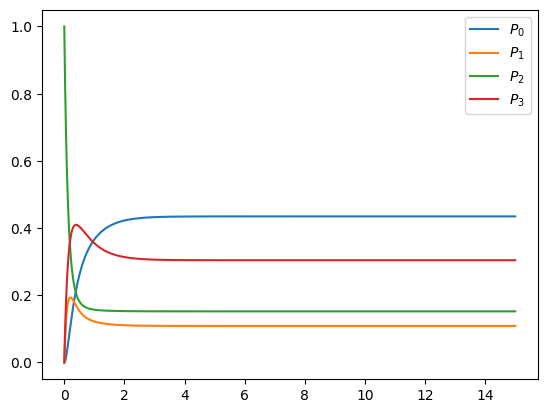

In [13]:
def draw_plot(ts: np.ndarray, ps: np.ndarray) -> None:
    for i, p in enumerate(ps):
        plt.plot(ts, p, label=f"$P_{{{i}}}$")
    plt.legend()
    plt.show()
    
tn = t_n_input.value
tmax = t_max_input.value

m = get_matrix()
ts, ps = solve_ode(m, m[0].copy(), tn, tmax)

draw_plot(ts, ps)

### Math

In [14]:
steady_ps = find_steady_ps(get_matrix())
steady_ts = find_steady_ts(ts, ps, steady_ps)

df = pd.DataFrame.from_dict(
    {
        "Вероятностная константа": steady_ps,
        "Время достижения вероятностной константы": steady_ts,
    },
    orient="index",
    columns=[f"$S_{{{i+1}}}$" for i in range(len(m))],
)
df.style.format("{:.3f}")

,$S_{1}$,$S_{2}$,$S_{3}$,$S_{4}$
Вероятностная константа,0.435,0.109,0.152,0.304
Время достижения вероятностной константы,7.520,6.499,5.840,7.357
